**Import necessary packages**

In [0]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwordsHere is a dataset consist of 2225 documents from the BBC news website comprising stories in five topical areas for the annual year 2004-2005.

Each document corresponds to news and we have 5 classes - business, entertainment, politics, sport, tech. 

You can find the document related to a specific class in their respective folders. i.e, documents related to entertainment class can be found in the entertainment folder and likewise for the other classes.
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict

import seaborn as sns

**Data Preparation**

1. Load the raw data zip file and unzip it

In [0]:
# Upload the raw dataset on colab
!unzip bbc-fulltext.zip
# !ls "./bbc"

In [444]:
# Get all the sub-directories name
dir = './bbc/'
_, dirs, _ = os.walk(dir).__next__()
print(dirs)
class_names = dirs

['business', 'politics', 'sport', 'entertainment', 'tech']


In [445]:
# Print total number of files in each sub-directory
for file in dirs:
  print(file , " : ", len(os.listdir(dir + file)))

business  :  510
politics  :  417
sport  :  511
entertainment  :  386
tech  :  401


2. Dataset creation

In [446]:
file_name = []
text = []
class_name = []

for folder in dirs:
  
  for file in os.listdir(dir + folder):
    
      if file.endswith(".txt"):
        
          file_path = os.path.join(dir,folder,file)
          file_name.append(file)
          with open(file_path, 'rb') as f:
            text.append(f.read())
          class_name.append(folder)
          
print(len(file_name),len(text),len(class_name))

2225 2225 2225


Let's see how our text data looks like: 

In [447]:
text[2]

b'Novartis hits acquisition trail\n\nSwiss drugmaker Novartis has announced 5.65bn euros ($7.4bn; \xc2\xa33.9bn) of purchases to make its Sandoz unit the world\'s biggest generic drug producer.\n\nNovartis, which last month forecast record sales for 2005, said it had bought all of Germany\'s Hexal. It also acquired 67.7% of Hexal\'s US affiliate Eon Labs, and offered to buy the remaining shares for $31 each. Novartis said that it would be able to make cost savings of about $200m a year following the acquisitions. Novartis\' shares rose 1% to 57.85 Swiss francs in early trading.\n\nThe deal will see Novartis\' Sandoz business overtake Israel\'s Teva Pharmaceuticals as the world\'s biggest maker of generics. Based on 2004 figures the newly merged producer would have sales of more than $5bn, the company estimated. Novartis said that it would merge a number of departments, adding that there may be job cuts.\n\n"The strong growth outlook for Sandoz, which will create jobs, is expected to pa

From above result we can see:
1. The text is in bytes form thus we need to decode it into string type,
2. There are unnecessary characters/tags like \n, "  " and \ . We have to remove them with " ".
3. There are unnecessary symbols like ?, ;, :, etc we have to remove them as they dont have any significance in our article classification objective.
4. Lots of stopping words like you, ourselves, ours, it, it's , etc we need to remove them too.

We will do all these steps to clean our data in Data cleaning section.

3. Now, let's create pandas DataFrame of our dataset and visulaize it.

In [448]:
# del list
df = pd.DataFrame(list(zip(file_name, text, class_name)), columns = ['File_Name', 'Text', 'Class_Name'])

# Create a new column which contains length of each text file (article)
article_len = df['Text'].str.len()

# Insert the new column in our dataframe df
df.insert(2, 'Raw_Text_length', article_len)

df.head()

,File_Name,Text,Raw_Text_length,Class_Name
0,490.txt,b'Brazil jobless rate hits new low\n\nBrazil\'...,1925,business
1,025.txt,b'Yukos loses US bankruptcy battle\n\nA judge ...,2704,business
2,201.txt,b'Novartis hits acquisition trail\n\nSwiss dru...,1764,business
3,463.txt,b'US economy still growing says Fed\n\nMost ar...,1051,business
4,402.txt,b'US interest rate rise expected\n\nUS interes...,1811,business


In [449]:
# Dimensions of our DataFrame
print(df.shape)

(2225, 4)


Now, let's calculate how the articles are distributed across each class (category) by plotting a Pie chart.

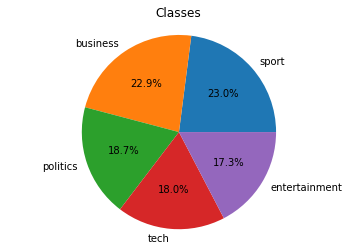

In [450]:
# visualizing data
classes = {}
classes = df.Class_Name.value_counts()

counts = []
names = []
for name, count in classes.items():
  counts.append(count)
  names.append(name)
  
fig, ax = plt.subplots()
ax.pie(counts, labels=names, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Classes')

# plt.legend(loc='upper right')
plt.show()
#almost equal distribution of each class

From the above figure, we can see that the articles are almost equally distributed across each catogory thus our data is equally distributed.

**Data Cleaning**

In [0]:
# decode the text into string type and clean the unnecessary tags
for i in range(len(text)):
  # I used ancient MS-DOS cp437 encoding
  text[i] = text[i].decode('cp437')
clean_string = lambda x: x.replace('\n', ' ').replace('  ', ' ')
text = [clean_string(item) for item in text]
df['Text'] = pd.DataFrame(text)

In [452]:
df['Text'].head()

0    Brazil jobless rate hits new low Brazil's unem...
1    Yukos loses US bankruptcy battle A judge has d...
2    Novartis hits acquisition trail Swiss drugmake...
3    US economy still growing says Fed Most areas o...
4    US interest rate rise expected US interest rat...
Name: Text, dtype: object

In [0]:
# remove unnecessary symobols like 's, . , ; , ?, : , ! and ,
df['Text'] = df['Text'].str.replace("'s", "").replace(".", "").replace(";", "").replace("?", "").replace(":", "").replace("!", "").replace(",", "")


In [454]:
df['Text'].head()

0    Brazil jobless rate hits new low Brazil unempl...
1    Yukos loses US bankruptcy battle A judge has d...
2    Novartis hits acquisition trail Swiss drugmake...
3    US economy still growing says Fed Most areas o...
4    US interest rate rise expected US interest rat...
Name: Text, dtype: object

It is important to lower case all the words in our text column because we don't want our classifier to see "My" and "my" differently as it would not make any sense.

In [0]:
# convert all uppercase letter to lower case
df['Text'] = df['Text'].str.lower()

Removing stop words.

In [456]:
# nltk.download('stopwords')

stop_words = list(stopwords.words('english'))

# print(stop_words[0:40])

print("There are total ", len(stop_words) ," stopwords.") # 179 stop words

There are total  179  stopwords.


In [0]:
# remove all the stopwords from our data
df['Updated_text'] = df['Text']

for s_w in stop_words:
  
  re_ex = r"\b" + s_w + r"\b" # add web url in reference
  df['Updated_text'] = df['Updated_text'].str.replace(re_ex, '')
  
# create a new column and calculate each article's text length  
df['Length_aftr_dc'] = df['Updated_text'].str.len()

In [458]:
df.head()

,File_Name,Text,Raw_Text_length,Class_Name,Updated_text,Length_aftr_dc
0,490.txt,brazil jobless rate hits new low brazil unempl...,1925,business,brazil jobless rate hits new low brazil unempl...,1630
1,025.txt,yukos loses us bankruptcy battle a judge has d...,2704,business,yukos loses us bankruptcy battle judge dismi...,2172
2,201.txt,novartis hits acquisition trail swiss drugmake...,1764,business,novartis hits acquisition trail swiss drugmake...,1418
3,463.txt,us economy still growing says fed most areas o...,1051,business,us economy still growing says fed areas us ...,896
4,402.txt,us interest rate rise expected us interest rat...,1811,business,us interest rate rise expected us interest rat...,1459


**Text Normalization** using Lemmatization :

In [459]:
# # download pre-trained Punkt tokenizer and WordNet database
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
# create an object of WordNetLemmatizer class
wordnet_lemma = WordNetLemmatizer()

In [0]:
lemmatized_text = []
num_articles = df.shape[0]

for i in range(0, num_articles):
  
  new_text = []
  
  text = df.loc[i]['Updated_text']
  splitted_text = text.split(" ") #.split(list("., "))
  
  for word in splitted_text:
    new_text.append(wordnet_lemma.lemmatize(word, pos="v")) #pos="a"))
#   print(new_text[0:2])  
  temp_text = " ".join(new_text) #gfg
  
  lemmatized_text.append(temp_text)
  

In [0]:
df['Lemma_text'] = lemmatized_text
df['Lemma_text_length'] = df['Lemma_text'].str.len()

Now, let's see how our raw data of article texts have been changed after Data cleaning and Text Normalization process. 

In [463]:
df['Raw_Text_length'] = pd.to_numeric(df['Raw_Text_length'])
raw_txt_len = df.groupby('Class_Name')['Raw_Text_length'].mean()
print("Average article length of each class before data cleaning and lemmatization:\n")
print(raw_txt_len)

df['Length_aftr_dc'] = pd.to_numeric(df['Length_aftr_dc'])
dc_txt_len = df.groupby('Class_Name')['Length_aftr_dc'].mean()
print("\nAverage article length of each class after data cleaning:\n")
print(dc_txt_len)

df['Lemma_text_length'] = pd.to_numeric(df['Lemma_text_length'])
lemma_txt_len = df.groupby('Class_Name')['Lemma_text_length'].mean()
print("\nAverage article length of each class after lemmatization:\n")
print(lemma_txt_len)

Average article length of each class before data cleaning and lemmatization:

Class_Name
business         1987.664706
entertainment    1929.339378
politics         2685.007194
sport            1897.485323
tech             2976.775561
Name: Raw_Text_length, dtype: float64

Average article length of each class after data cleaning:

Class_Name
business         1614.480392
entertainment    1537.658031
politics         2108.856115
sport            1474.904110
tech             2349.927681
Name: Length_aftr_dc, dtype: float64

Average article length of each class before data cleaning and lemmatization:

Class_Name
business         1557.621569
entertainment    1489.163212
politics         2035.021583
sport            1429.373777
tech             2266.635910
Name: Lemma_text_length, dtype: float64


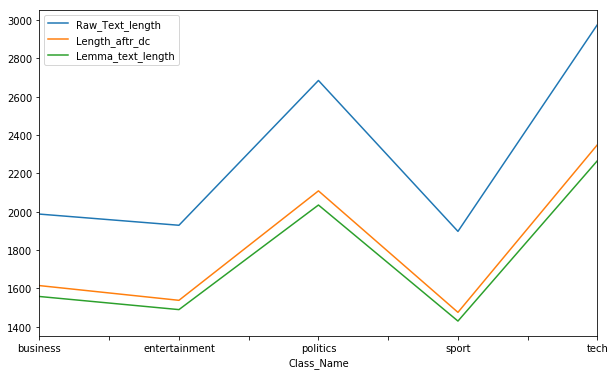

In [464]:
# visualize the difference by plotting a graph
plt.figure(figsize=(10,6))
raw_txt_len.plot()
dc_txt_len.plot()
lemma_txt_len.plot()
plt.legend()
plt.show();

From the above graph we can see that how average length of each class' article has been changed after Data cleaning and Text Normalization process. 

Create final DataFrame:

In [465]:
my_df = df[["File_Name","Lemma_text","Lemma_text_length","Class_Name",]]
my_df.head()

,File_Name,Lemma_text,Lemma_text_length,Class_Name
0,490.txt,brazil jobless rate hit new low brazil unemplo...,1592,business
1,025.txt,yukos lose us bankruptcy battle judge dismis...,2100,business
2,201.txt,novartis hit acquisition trail swiss drugmaker...,1372,business
3,463.txt,us economy still grow say feed areas us saw...,859,business
4,402.txt,us interest rate rise expect us interest rat ...,1402,business


**Feature Engineering**

In [466]:
my_df.head()

,File_Name,Lemma_text,Lemma_text_length,Class_Name
0,490.txt,brazil jobless rate hit new low brazil unemplo...,1592,business
1,025.txt,yukos lose us bankruptcy battle judge dismis...,2100,business
2,201.txt,novartis hit acquisition trail swiss drugmaker...,1372,business
3,463.txt,us economy still grow say feed areas us saw...,859,business
4,402.txt,us interest rate rise expect us interest rat ...,1402,business


In [0]:
# class label encoding
label_enc = LabelEncoder()
class_id_values = label_enc.fit_transform(my_df['Class_Name']) 
my_df.insert(4, 'Class_id', class_id_values)

In [468]:
my_df.head()

,File_Name,Lemma_text,Lemma_text_length,Class_Name,Class_id
0,490.txt,brazil jobless rate hit new low brazil unemplo...,1592,business,0
1,025.txt,yukos lose us bankruptcy battle judge dismis...,2100,business,0
2,201.txt,novartis hit acquisition trail swiss drugmaker...,1372,business,0
3,463.txt,us economy still grow say feed areas us saw...,859,business,0
4,402.txt,us interest rate rise expect us interest rat ...,1402,business,0


In [469]:
my_df['Class_id'].value_counts()

3    511
0    510
2    417
4    401
1    386
Name: Class_id, dtype: int64

Train-Test_Split

In [0]:
.
X_train, X_test, y_train, y_test = train_test_split(my_df['Lemma_text'],my_df['Class_id'],
                                                    test_size=0.25, random_state=8)

In [471]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1668,) (557,) (1668,) (557,)


**Text representation**

In [0]:
# TfidfVectorizer

vectorizer = TfidfVectorizer(encoding = 'utf-8',
                        ngram_range = (1,2),
                        stop_words = None,
                        lowercase = False,
                        max_df = 1.0,
                        min_df = 10,
                        max_features = 400,
                        norm='l2',
                        sublinear_tf=True
                       )

In [0]:
# train-test set transformation
# train
features_train = vectorizer.fit_transform(X_train).toarray()
labels_train = y_train
# test
features_test = vectorizer.transform(X_test).toarray()
labels_test = y_test

In [474]:
# train
features_train = vectorizer.fit_transform(X_train).toarray()
labels_train = y_train
# test
features_test = vectorizer.transform(X_test).toarray()
labels_test = y_test

print(features_train.shape)
print(features_test.shape)

(1668, 400)
(557, 400)


**Building Classifier**

For building a perfect classifier for our article class classification task, I will use Random Forest Model. First we will find best values for parameters of Random Forest using Randomized Search Cross Validation.

In [475]:
# select parameters to be tuned

# n_estimators (The number of trees in the forest)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_depth (The maximum depth of the tree)
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split (The minimum number of samples required to split an internal node)
min_samples_split = [2, 5, 10]

# min_samples_leaf (The minimum number of samples required to be at a leaf node)
min_samples_leaf = [1, 2, 4]

# bootstrap (Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree)
bootstrap = [True, False]

# max_features (The number of features to consider when looking for the best split)
max_features = ['auto', 'sqrt']



# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [20, 40, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [478]:
# create model
rf_model = RandomForestClassifier(n_jobs=-1,random_state=8)

# Randomized Search Cross Validation
randomSCV = RandomizedSearchCV(estimator=rf_model,
                              param_distributions=random_grid,
                              n_iter=50,
                             scoring='accuracy',
                              cv=3,
                              verbose=1,
                               n_jobs=-1,
                              random_state=8)

randomSCV.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1, 

In [480]:
print("The best hyperparameters from Random Search are:")
print(randomSCV.best_params_)
print("========================================================================================================")
print("\nThe mean accuracy of a model with these hyperparameters is:")
print(randomSCV.best_score_ * 100)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
94.7841726618705


In [481]:
# save the best model
my_rfc = randomSCV.best_estimator_
my_rfc

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=80, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

In [0]:
# fit model to training data and predict labels on test data
my_rfc.fit(features_train, labels_train)
pred_labels = my_rfc.predict(features_test)
# pred_labels[0:5]

In [495]:
# training accuracy
print(accuracy_score(labels_train, my_rfc.predict(features_train)) * 100)

print("=====================================================================================")

# test accuracy
print("The mean or classification accuracy of RandomForest model on test data is:")
rfc_accuracy = accuracy_score(labels_test, pred_labels) * 100
print(rfc_accuracy)

100.0
The mean or classification accuracy of RandomForest model on test data is:
95.15260323159784


For further visualization of evaluation of performance our model I will use Confusion Matrix.

In [485]:
# generate confusion matrix
# add web url in reference -- 
conf_matrix = confusion_matrix(labels_test, pred_labels)
conf_matrix

array([[129,   1,   4,   0,   1],
       [  2,  86,   2,   2,   1],
       [  4,   0,  99,   0,   2],
       [  2,   2,   0, 124,   0],
       [  3,   0,   0,   1,  92]])

For better visualization, I will build heatmap of Confusion matrix

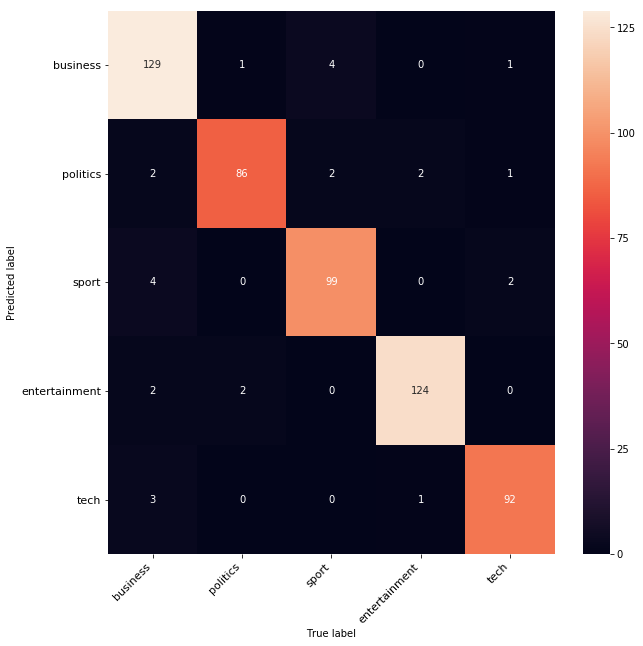

In [486]:
# create dataframe of Confusion Matrix
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# heatmap
fig = plt.figure(figsize=(10,10))
fontsize = 11

try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show();

**Classification using Word Embedding Model GloVe:**

In [0]:
# split text and remove duplicates
split_func = lambda x: list(dict.fromkeys(x["Lemma_text"].split()))

X = my_df.apply(split_func, axis=1)
y = my_df["Class_id"]

In [490]:
# Getting the embedding model
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-09-22 11:30:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-09-22 11:30:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-09-22 11:30:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
# Load and prepare word embeddings from GloVe Model
import struct

glove_dict = {}
all_words = set(w for words in X for w in words)
with open("glove.6B.50d.txt", "rb") as infile:
  for line in infile:
    parts = line.split()
    word = parts[0].decode("utf-8")
    if(word in all_words):
      nums = np.array(parts[1:], dtype=np.float32)
      glove_dict[word] = nums

In [492]:
# Total words in our dataset (dictionary) - X
print(len(all_words))

53195


Building features

In [0]:
# First by averaging word vectors of all words in a text file (row/article)

class MeanEmbeddingVectorizer(object):
  def __init__(self, word2vec):
    self.word2vec = word2vec
    if len(word2vec)>0:
      self.dim=len(word2vec[next(iter(word2vec))])
    else:
      self.dim=0
    
  def fit(self, X, y):
    return self
  
  def transform(self, X):
    return np.array([
        np.mean([self.word2vec[w] for w in words if w in self.word2vec]
               or [np.zeros(self.dim)], axis=0)
        for words in X
    ])

In [502]:
glove_mean = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_dict)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=500))])

cvs_mean = cross_val_score(glove_mean, X, y, cv=4).mean() * 100 
print("The mean or classification accuracy of pretrained GloVe (mean) model is:")
print(cvs_mean)

The mean or classification accuracy of pretrained GloVe (mean) model is:
95.77261088217988


In [0]:
# Now usinfg tfidf weighting method

class TfidfEmbeddingVectorizer(object):
  def __init__(self, word2vec):
    
    self.word2vec = word2vec
    self.word2weight = None
    if len(word2vec)>0:
      self.dim=len(word2vec[next(iter(word2vec))])
    else:
      self.dim=0
    
  def fit(self, X, y):
    
    tfidf = TfidfVectorizer(analyzer=lambda x:x)
    tfidf.fit(X)
    
    # if a word was never seen - it must be at least as infrequent as any of the
    # known words - so the default idf is the max of known idf's
    max_idf = max(tfidf.idf_)
    self.word2weight = defaultdict(
        lambda: max_idf, 
        [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

    return self
  
  def transform(self, X):
    
    return np.array([
        np.mean([self.word2vec[w] * self.word2weight[w]
                for w in words if w in self.word2vec] or
               [np.zeros(self.dim)], axis=0)
        for words in X
    ])

In [505]:
glove_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_dict)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=500))])

cvs_tfidf = cross_val_score(glove_tfidf, X, y, cv=5).mean() * 100
print("The mean or classification accuracy of pretrained GloVe (tfidf weight) model is:")
print(cvs_tfidf)

The mean or classification accuracy of pretrained GloVe (tfidf weight) model is:
95.27842609865083


**RESULTS**

In [0]:
result = [("Random Forest",rfc_accuracy), ("glove_mean",cvs_mean), ("glove_tfidf",cvs_tfidf)]

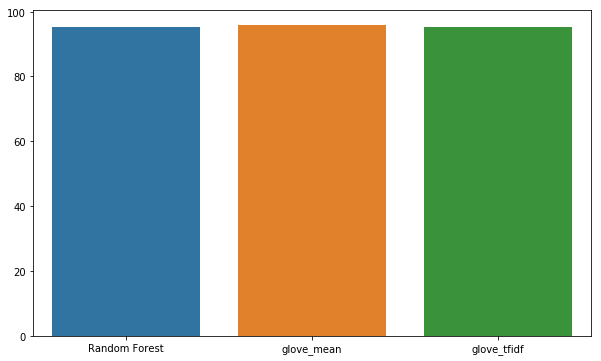

In [507]:
plt.figure(figsize=(10,6))
sns.barplot(x = [name for name, _ in result], y = [score for _, score in result]);

In [508]:
print(result)

[('Random Forest', 95.15260323159784), ('glove_mean', 95.77261088217988), ('glove_tfidf', 95.27842609865083)]
